# Fantasy PL Player Performance
code from: https://medium.com/analytics-vidhya/getting-started-with-fantasy-premier-league-data-56d3b9be8c32

## Get player data and gameweek data

Import packages

In [1]:
import pandas as pd
import re
import random
import requests

Get data from the FPL API

In [2]:
# set url for fantasy PL API
api_url = "https://fantasy.premierleague.com/api/bootstrap-static/"

# download the webpage
data = requests.get(api_url)

json = data.json()

json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

Build a Pandas dataframe from the json data

In [3]:
# build a dataframe
players = pd.DataFrame(json['elements'])

players.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam',
       'news', 'news_added', 'now_cost', 'photo', 'points_per_game',
       'second_name', 'selected_by_percent', 'special', 'squad_number',
       'status', 'team', 'team_code', 'total_points', 'transfers_in',
       'transfers_in_event', 'transfers_out', 'transfers_out_event',
       'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_con

Cleaning up the player data and selecting columns (if desired)

In [4]:
#select only relevant columns from elements_df, not all needed at this point but maybe useful in the future
#players_df_select = elements_df[['first_name','second_name','team','element_type','selected_by_percent',
#                                'now_cost','minutes','transfers_in','value_season','total_points']]

# use all columns 
players_df_select = players

# combine first and last names to get player full names
players_df_select['full_name'] = players_df_select[['first_name', 'second_name']].agg(' '.join, axis=1)

# drop first and last name columns
players_df_select = players_df_select.drop(['first_name', 'second_name'], axis = 1)

# player prices are 10x the true value. Divide the prices by 10 to get the true values
players_df_select['now_cost'] = players_df_select['now_cost']/10

players_df_select.head()

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,...,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,full_name
0,100.0,100.0,58822,0,0,-3,3,0,2,0.0,...,157,451,174,394,145,399,149,0.00000,0.00000,Cédric Alves Soares
1,NaN,NaN,84450,0,0,1,-1,1,3,3.0,...,100,115,48,45,18,89,28,1.06546,0.43872,Granit Xhaka
2,100.0,100.0,153256,0,0,-3,3,1,3,0.7,...,293,264,125,365,159,196,60,0.81081,0.00000,Mohamed Elneny
3,NaN,NaN,156074,0,0,-3,3,0,2,0.3,...,163,312,106,398,149,420,157,0.00000,0.00000,Rob Holding
4,100.0,100.0,167199,0,0,-2,2,0,3,2.0,...,158,162,67,107,50,248,82,1.03960,0.59406,Thomas Partey


Get team info

In [5]:
# get team info
teams = pd.DataFrame(json['teams'])

teams.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,0,ARS,...,None,False,0,1220,1270,1240,1250,1200,1270,1
1,7,0,None,2,0,Aston Villa,0,0,0,AVL,...,None,False,0,1090,1100,1110,1130,1090,1110,2
2,91,0,None,3,0,Bournemouth,0,0,0,BOU,...,None,False,0,1060,1090,1070,1130,1050,1080,127
3,94,0,None,4,0,Brentford,0,0,0,BRE,...,None,False,0,1100,1130,1100,1110,1130,1160,130
4,36,0,None,5,0,Brighton,0,0,0,BHA,...,None,False,0,1150,1160,1140,1160,1170,1190,131


Get position info

In [6]:
# get position information from 'element_types'
positions = pd.DataFrame(json['element_types'])

positions.head()

,id,plural_name,plural_name_short,singular_name,singular_name_short,squad_select,squad_min_play,squad_max_play,ui_shirt_specific,sub_positions_locked,element_count
0,1,Goalkeepers,GKP,Goalkeeper,GKP,2,1,1,True,[12],72
1,2,Defenders,DEF,Defender,DEF,5,3,5,False,[],236
2,3,Midfielders,MID,Midfielder,MID,5,2,5,False,[],296
3,4,Forwards,FWD,Forward,FWD,3,1,3,False,[],83


Merge the players with their teams

In [7]:
# merge player data with teams and positions
player_team_merge = pd.merge(
    left = players_df_select,
    right = teams,
    left_on = 'team',
    right_on = 'id'
)

player_team_merge[['full_name', 'name']].head()

,full_name,name
0,Cédric Alves Soares,Arsenal
1,Granit Xhaka,Arsenal
2,Mohamed Elneny,Arsenal
3,Rob Holding,Arsenal
4,Thomas Partey,Arsenal


Merge the players with their positions

In [8]:
player_team_pos_merge = pd.merge(
    left = player_team_merge,
    right = positions,
    left_on = 'element_type',
    right_on = 'id'
)

player_team_pos_merge[['full_name', 'name', 'singular_name_short']].head()

,full_name,name,singular_name_short
0,Cédric Alves Soares,Arsenal,DEF
1,Rob Holding,Arsenal,DEF
2,Kieran Tierney,Arsenal,DEF
3,Benjamin White,Arsenal,DEF
4,Takehiro Tomiyasu,Arsenal,DEF


In [9]:
# rename columns
player_team_pos_merge = player_team_pos_merge.rename(
    columns={'name':'team_name', 'singular_name_short':'position_name'}
)

player_team_pos_merge[['full_name', 'team_name', 'position_name']].head()

,full_name,team_name,position_name
0,Cédric Alves Soares,Arsenal,DEF
1,Rob Holding,Arsenal,DEF
2,Kieran Tierney,Arsenal,DEF
3,Benjamin White,Arsenal,DEF
4,Takehiro Tomiyasu,Arsenal,DEF


Get player gameweek data from https://fantasy.premierleague.com/api/element-summary/

In [10]:
# function for getting specific player gameweek history
def get_history(player_id):
    ''' get all gameweek history for a given player'''
    
    # request data from API 
    data = requests.get("https://fantasy.premierleague.com/api/element-summary/" + str(player_id) + "/")
    json = data.json()
    
    # turn data into Pandas dataframe
    df = pd.DataFrame(json['history'])
    
    return df

get_history(1)  

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,...,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,value,transfers_balance,selected,transfers_in,transfers_out
0,1,1,7,0,False,2022-08-05T19:00:00Z,0,2,1,0,...,0,0.00000,0.00000,0.00000,0.00000,45,0,23970,0,0
1,1,11,10,0,True,2022-08-13T14:00:00Z,4,2,2,0,...,0,0.00000,0.00000,0.00000,0.00000,44,-5169,24193,1361,6530
2,1,21,3,0,False,2022-08-20T16:30:00Z,0,3,3,0,...,0,0.00000,0.00000,0.00000,0.00000,44,-4337,20960,879,5216
3,1,31,9,0,True,2022-08-27T16:30:00Z,2,1,4,0,...,0,0.00000,0.00000,0.00000,0.00000,43,-2988,18825,577,3565
4,1,41,2,0,True,2022-08-31T18:30:00Z,2,1,5,0,...,0,0.00000,0.00000,0.00000,0.00000,43,-1611,17790,405,2016
5,1,56,14,0,False,2022-09-04T15:30:00Z,3,1,6,0,...,0,0.00000,0.00000,0.00000,0.00000,42,-1207,17133,516,1723
6,1,72,4,0,False,2022-09-18T11:00:00Z,0,3,8,0,...,0,0.00000,0.00000,0.00000,0.00000,42,-445,16837,114,559
7,1,81,18,0,True,2022-10-01T11:30:00Z,3,1,9,0,...,0,0.00000,0.00000,0.00000,0.00000,42,-1572,15362,64,1636
8,1,91,12,0,True,2022-10-09T15:30:00Z,3,2,10,0,...,0,0.00000,0.00000,0.00000,0.00000,42,-828,14630,148,976
9,1,104,11,0,False,2022-10-16T13:00:00Z,0,1,11,0,...,0,0.00000,0.00000,0.00000,0.00000,42,-229,14586,227,456


In [11]:
from tqdm.auto import tqdm
tqdm.pandas()

In [12]:
# join team name
players = players.merge(
    teams[['id', 'name']],
    left_on='team',
    right_on='id',
    suffixes=['_player', None]
).drop(['team', 'id'], axis=1)

# join player positions
players = players.merge(
    positions[['id', 'singular_name_short']],
    left_on='element_type',
    right_on='id'
).drop(['element_type', 'id'], axis=1)

# rename columns
players = players.rename(
    columns={'name':'team', 'singular_name_short':'position'}
)

players.head()


,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,ep_next,ep_this,...,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,full_name,team,position
0,100.0,100.0,58822,0,0,-3,3,0,0.0,0.5,...,174,394,145,399,149,0.00000,0.00000,Cédric Alves Soares,Arsenal,DEF
1,NaN,NaN,156074,0,0,-3,3,0,0.3,0.8,...,106,398,149,420,157,0.00000,0.00000,Rob Holding,Arsenal,DEF
2,100.0,100.0,192895,0,0,-3,3,0,0.7,1.2,...,94,340,125,192,70,0.80537,0.20134,Kieran Tierney,Arsenal,DEF
3,NaN,NaN,198869,0,0,2,-2,0,3.3,3.8,...,28,36,10,28,9,1.11354,0.58952,Benjamin White,Arsenal,DEF
4,100.0,100.0,223723,0,0,-3,3,0,0.3,0.8,...,108,311,112,236,88,0.80357,0.40179,Takehiro Tomiyasu,Arsenal,DEF


In [13]:
# get gameweek history for all players
points = players['id_player'].progress_apply(get_history)

# combine results into one dataframe
points = pd.concat(df for df in points)

# join full_name
points = players[['id_player', 'full_name', 'team', 'position']].merge(
    points,
    left_on='id_player',
    right_on='element'
)

  0%|          | 0/687 [00:00<?, ?it/s]

In [14]:
# save the dataframe to csv
# points.to_csv('points_20220105')

## Further Analysis

get 20 top scoring players by position

In [18]:
# import test data
points = pd.read_csv('points_20220105')

In [19]:
# get 20 top scoring keepers
gks = points.loc[points['position'] == 'GKP']
defs = points.loc[points['position'] == 'DEF']
mids = points.loc[points['position'] == 'MID']
fwds = points.loc[points['position'] == 'FWD']

top_20_gks = gks.groupby(
    ['element', 'full_name']
).agg(
    {'total_points':'sum'}
).reset_index(
).sort_values(
    'total_points', ascending=False
).head(20)

top_20_defs = defs.groupby(
    ['element', 'full_name']
).agg(
    {'total_points':'sum'}
).reset_index(
).sort_values(
    'total_points', ascending=False
).head(20)

top_20_mids = mids.groupby(
    ['element', 'full_name']
).agg(
    {'total_points':'sum'}
).reset_index(
).sort_values(
    'total_points', ascending=False
).head(20)

top_20_fwds = fwds.groupby(
    ['element', 'full_name']
).agg(
    {'total_points':'sum'}
).reset_index(
).sort_values(
    'total_points', ascending=False
).head(20)

top_20_fwds.head()

,element,full_name,total_points
35,318,Erling Haaland,144
49,427,Harry Kane,127
8,80,Ivan Toney,100
23,210,Aleksandar Mitrović,81
1,28,Gabriel Fernando de Jesus,69


combine top scoring players into one dataframe

In [20]:
top_20_all_pos = pd.concat([top_20_gks, top_20_defs, top_20_mids, top_20_fwds], axis = 0)

top_20_all_pos.sort_values('total_points', ascending=False).head()

,element,full_name,total_points
35,318,Erling Haaland,144
49,427,Harry Kane,127
122,357,Kieran Trippier,124
162,369,Miguel Almirón Rejala,106
3,7,Martin Ødegaard,103


Let's try to compare performance over the past 5 matches with performance in the most recent match

For a given player we need to:
- get the last 6 results from the points dataframe
- take the average of each performance stat over the first 5/6 observations
- see if any performance stats predict performance in the 6th fixture

The analysis will be different for players in different positions. Attacking players get most of their points from goal involvements, while defenders and goalkeepers get more points from clean sheets.

In [29]:
# select columns of interest
points_select = points[['id_player', 'full_name', 'team', 'position',
                        'total_points',
                        'minutes', 'goals_scored', 'assists', 'clean_sheets', 
                        'goals_conceded', 'own_goals',
                        'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index',
                        'expected_goals', 'expected_assists', 'expected_goal_involvements', 
                        'expected_goals_conceded']]

In [79]:
def last_5_player(df, player_id):
    ''' 
    get the mean stats for a given player_id over the last 5 fixtures
    prior to most recent fixture and the total points from the most 
    recent fixture. 
    
    assume dataframe is sorted from oldest to newest fixtures
    '''
    df = df[df['id_player'] == player_id]
    
    last_6 = df.tail(6) 
    
    last_5 = last_6.head(5)
    
    recent = last_6['total_points'].tail(1)
    
    d = {'name': last_5['full_name'].iloc[0],
         'id': last_5['id_player'].iloc[0],
         'team': last_5['team'].iloc[0],
        'position': last_5['position'].iloc[0],
        'mean_points': last_5['total_points'].mean(),
        'mean_minutes': last_5['minutes'].mean(),
        'mean_goals_scored': last_5['goals_scored'].mean(),
        'mean_assists': last_5['assists'].mean(),
        'mean_clean_sheets': last_5['clean_sheets'].mean(),
        'mean_goals_conceded': last_5['goals_conceded'].mean(),
        'mean_own_goals': last_5['own_goals'].mean(),
        'mean_saves': last_5['saves'].mean(),
        'mean_bonus': last_5['bonus'].mean(),
        'mean_bps': last_5['bps'].mean(),
        'mean_influence': last_5['influence'].mean(),
        'mean_creativity': last_5['creativity'].mean(),
        'mean_threat': last_5['threat'].mean(),
        'mean_ict': last_5['ict_index'].mean(),
        'mean_xg': last_5['expected_goals'].mean(),
        'mean_xa': last_5['expected_assists'].mean(),
        'mean_xgi': last_5['expected_goal_involvements'].mean(),
        'mean_xgc': last_5['expected_goals_conceded'].mean(),}
    
    last_5_mean = pd.DataFrame(data = d, index = [0])
    
    last_5_mean['latest_points'] = recent.iloc[0]
    
    return last_5_mean

# test for Bukayo Saka (id = 13)
last_5_player(points_select, 13)

,name,id,team,position,mean_points,mean_minutes,mean_goals_scored,mean_assists,mean_clean_sheets,mean_goals_conceded,...,mean_bps,mean_influence,mean_creativity,mean_threat,mean_ict,mean_xg,mean_xa,mean_xgi,mean_xgc,latest_points
0,Bukayo Saka,13,Arsenal,MID,5.4,77.2,0.4,0.4,0.4,0.6,...,20.0,29.28,39.24,14.0,8.26,0.25732,0.168212,0.425532,0.64568,3


In [77]:
def last_5_all(df):
    ''' get last mean stats for all players in df over the last 5 fixtures
    prior to most recent fixture and the total points from the most 
    recent fixture.
    '''
    last_5_all = pd.DataFrame() # empty dataframe
    for p in df['id_player'].unique():
        player_df = last_5_player(df, p)
        last_5_all = pd.concat([last_5_all, player_df])
    return last_5_all

In [81]:
# testing
subset = points_select[points_select['id_player'].isin([12, 13])]

last_5_all(subset)

,name,id,team,position,mean_points,mean_minutes,mean_goals_scored,mean_assists,mean_clean_sheets,mean_goals_conceded,...,mean_bps,mean_influence,mean_creativity,mean_threat,mean_ict,mean_xg,mean_xa,mean_xgi,mean_xgc,latest_points
0,Emile Smith Rowe,12,Arsenal,MID,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.00,0.00000,0.000000,0.000000,0.00000,0
0,Bukayo Saka,13,Arsenal,MID,5.4,77.2,0.4,0.4,0.4,0.6,...,20.0,29.28,39.24,14.0,8.26,0.25732,0.168212,0.425532,0.64568,3


Let's get the last 5 games performance and most recent performance for all the players

In [84]:
last_5_df = last_5_all(points_select)

last_5_df.head()

,name,id,team,position,mean_points,mean_minutes,mean_goals_scored,mean_assists,mean_clean_sheets,mean_goals_conceded,...,mean_bps,mean_influence,mean_creativity,mean_threat,mean_ict,mean_xg,mean_xa,mean_xgi,mean_xgc,latest_points
0,Cédric Alves Soares,1,Arsenal,DEF,0.4,5.6,0.0,0.0,0.0,0.0,...,1.0,0.48,0.32,0.0,0.08,0.00000,0.001958,0.001958,0.00870,0
0,Rob Holding,5,Arsenal,DEF,0.4,0.8,0.0,0.0,0.0,0.0,...,1.2,0.20,0.00,0.0,0.02,0.00000,0.000000,0.000000,0.02810,0
0,Kieran Tierney,8,Arsenal,DEF,0.8,25.6,0.0,0.0,0.0,0.6,...,4.2,3.48,3.04,0.8,0.74,0.00000,0.010344,0.010344,0.36994,0
0,Benjamin White,10,Arsenal,DEF,4.4,83.8,0.0,0.0,0.6,0.2,...,21.0,13.48,16.18,3.6,3.34,0.05678,0.120242,0.177022,0.56658,7
0,Takehiro Tomiyasu,14,Arsenal,DEF,1.2,18.4,0.0,0.0,0.2,0.4,...,5.8,2.04,3.26,3.6,0.88,0.01570,0.007934,0.023634,0.23434,1


In [85]:
# save the data to csv
#last_5_df.to_csv('last_5_gw14-19')

**Exploratory analysis:** 
starting with midfielders as this is the most varied category of players

Let's look at correlation between the variables. First we'll filter to midfield players who had at least 5 points over 5 games (made 5 appearances). 

In [95]:
# filter mids who have >=5 FPL points over the last 5 games
last_5_df_filter = last_5_df[(last_5_df['mean_points'] >= 5) & (last_5_df['position'] == 'MID')]

In [86]:
import seaborn as sns

<AxesSubplot:>

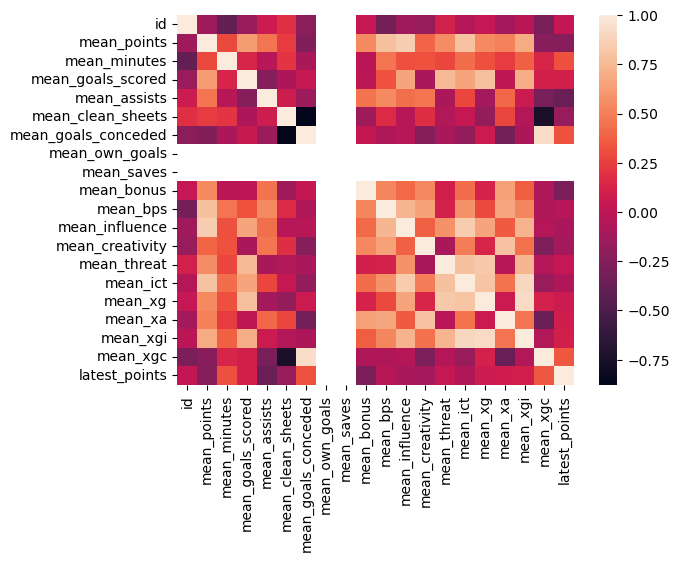

In [93]:
sns.heatmap(last_5_df_filter.corr())

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'mean_points'}>,
        <AxesSubplot:title={'center':'mean_minutes'}>,
        <AxesSubplot:title={'center':'mean_goals_scored'}>],
       [<AxesSubplot:title={'center':'mean_assists'}>,
        <AxesSubplot:title={'center':'mean_clean_sheets'}>,
        <AxesSubplot:title={'center':'mean_goals_conceded'}>,
        <AxesSubplot:title={'center':'mean_own_goals'}>],
       [<AxesSubplot:title={'center':'mean_saves'}>,
        <AxesSubplot:title={'center':'mean_bonus'}>,
        <AxesSubplot:title={'center':'mean_bps'}>,
        <AxesSubplot:title={'center':'mean_influence'}>],
       [<AxesSubplot:title={'center':'mean_creativity'}>,
        <AxesSubplot:title={'center':'mean_threat'}>,
        <AxesSubplot:title={'center':'mean_ict'}>,
        <AxesSubplot:title={'center':'mean_xg'}>],
       [<AxesSubplot:title={'center':'mean_xa'}>,
        <AxesSubplot:title={'center':'mean_xgi'}>,
        <AxesSubplot

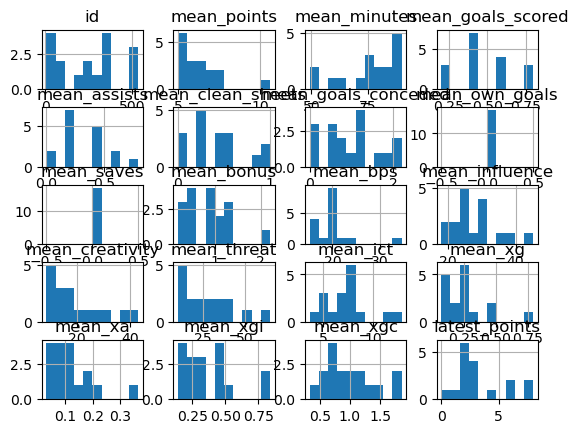

In [94]:
last_5_df_filter.hist()